# Model 3
This script uses the original [Wikiart](https://github.com/cs-chan/ArtGAN/blob/master/WikiArt%20Dataset/README.md) Dataset instead of deeplake
- Script will train Net2() in 6 classes: Expressionism, Realism, Romanticism, Baroque, Ukiyo-e, and Minimalism 

In [11]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.utils.data as data
from pprint import pprint
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
import numpy as np
import torch.optim as optim
import torch.nn.functional as F
import datetime

ImageFile.LOAD_TRUNCATED_IMAGES = True

## Preprocessing Data
Transform dataset and split into training and validation subsets

In [8]:
root = "./model3/wikiart"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.CenterCrop(227),
    # transforms.Normalize(mean = (0.4936, 0.4432, 0.3787), std=(0.2821, 0.2745, 0.2655)) # Expressionism, Romanticism, Realism
    transforms.Normalize(mean = (0.4923, 0.4398, 0.3775), std=(0.2874, 0.2797, 0.2695)) # 6 classes
])

'''
train data is a ImageFolder object.
ds.classes = list of the 24 classes in the dataset
ds.img = list of tuples of (img_path, label)
'''
dataset = datasets.ImageFolder(root=root, transform=transform)
print("- Number of train samples:", len(dataset))
print("- Classes:", dataset.classes, "| Length:", len(dataset.classes))
# print(dataset.imgs[20000])
# pprint("- Classes:\n", train_data.classes)

print("\nSplitting dataset into training and validation sets")
# Splitting Dataset into training and dataset

# splitting train val in a 0.8/0.2 ratio
train_len = int(len(dataset)*0.8)
val_len = len(dataset)- train_len
train, val = data.random_split(dataset, [train_len, val_len])
print("\t- Size of Training set:", len(train))
print("\t- Size of Validation set:", len(val))

# Dataloaders
train_dataloader = data.DataLoader(train, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val, batch_size=32, shuffle=False, drop_last=True)

- Number of train samples: 31233
- Classes: ['Baroque', 'Expressionism', 'Minimalism', 'Realism', 'Romanticism', 'Ukiyo_e'] | Length: 6

Splitting dataset into training and validation sets
	- Size of Training set: 24986
	- Size of Validation set: 6247


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


labels: tensor([4, 3, 1, 3, 4, 2, 1, 1, 1, 3, 3, 4, 4, 4, 4, 0, 0, 0, 1, 4, 3, 3, 3, 4,
        3, 1, 0, 4, 3, 4, 4, 4]) <class 'torch.Tensor'>


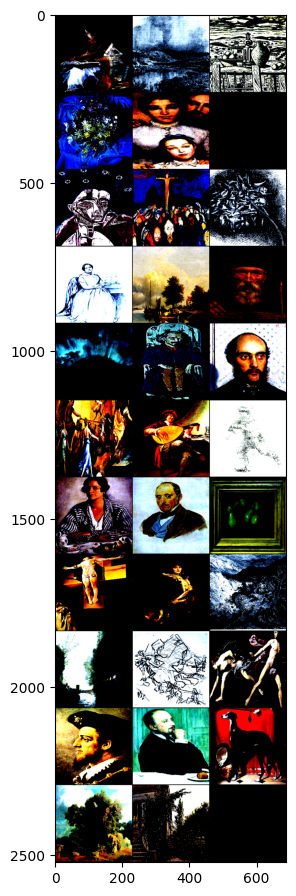

In [9]:
def show_transformed_images(dataset):
    dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)
    batch = next(iter(dataloader))
    images, labels = batch
    
    grid = torchvision.utils.make_grid(images, nrow=3)
    plt.figure(figsize=(11,11))
    plt.imshow(np.transpose(grid, (1,2,0)))
    print("labels:", labels, type(labels))
    
show_transformed_images(dataset)

# Calculate Mean and Standard Deviation of Dataset Images
Values to be used to Normalize dataloader

In [12]:
'''
Calculating mean and standard deviation for transforms
REMEMBER TO USE A NON-NORMALIZED DATASET TO GET VALUES
'''

# def get_mean_and_std(loader):
#     mean, std = 0, 0
#     total_images_count = 0
#     for img, _ in loader:
#         batch_size = img.size(0)
#         img = img.view(batch_size, img.size(1), -1) # reshape images in batch
#         mean += img.mean(2).sum(0)
#         std += img.std(2).sum(0)
#         total_images_count += batch_size
        
#     mean /= total_images_count
#     std /= total_images_count
    
    # return mean, std

dataloader = data.DataLoader(dataset, batch_size=32, shuffle=True)

def get_mean_and_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in loader:
        channels_sum += torch.mean(data, dim=[0,2,3]) # B x W x H
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1
    
    mean = channels_sum/num_batches
    std = (channels_squared_sum/num_batches - mean**2)**0.5
    return mean, std

mean, std = get_mean_and_std(dataloader)
print("mean:", mean, " std: ", std, "")
## mean: (0.5322, 0.4754, 0.4146), std: (0.2907, 0.2803, 0.2766) -> all images
## mean: tensor([-0.0953, -0.0682, -0.0931]) | std: tensor([0.9244, 0.9452, 0.9501]) -> only Impressionism, Realism, and Romanticism
## mean = (0.4980, 0.4494, 0.3860), std=(0.2845, 0.2786, 0.2711) -> Expressionism, Realism, Romanticism, resized to 64x64
## tensor([0.5002, 0.4418, 0.3726])  std:  tensor([0.2802, 0.2686, 0.2566]), rezied to 64x64, cropped to 32 x 32
## mean: tensor([0.4936, 0.4432, 0.3787])  std:  tensor([0.2821, 0.2745, 0.2655]) -> Realism, Romanticism, Expressionism 227 x 227

KeyboardInterrupt: 

# Model 3: 8 layers
- 5 convolutional layers, 3 fully-connected layers
- Max-pooling is applied after 1st, 2nd, and 3rd convolutional layers
- Dropout is applied after 2 first 2 fully connected layers
- ReLu activation functions are used in all layers (we chose ReLu over Tanh for faster forward computations)
- Applied log softmax in output layer to compute probabilities (we are using Negative Log Likeligood Loss for training)

In [14]:
import torch.nn as nn
#   output= ((Input-filter size)/ stride)+1
class Net2(nn.Module):
    def __init__(self, n_classes) -> None:
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        
        # 3 fully connected layers
        # Apply dropout after first 2 fc
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, n_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = F.log_softmax(out, dim=1) # calculate probabilities
        return out
        
Net2(3)
        

Net2(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
 

# Training Loop and Validation Functions

In [15]:
def training_loop(train_loader, model, loss_fn, optimizer, device, n_epochs):
    print("Started Training at {}".format(datetime.datetime.now()))
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # move data to device
            imgs = imgs.to(device=device)
            labels = labels.to(device=device)
            
            outputs = model(imgs) # compute output batch
            loss = loss_fn(outputs, labels) # compute loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            
        # if epoch == 1 or epoch % 10 == 0:
        # print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        print('{} Epoch {}, Training loss {}'.format(datetime.datetime.now(), epoch, loss_train / len(train_loader)))
            
def validate(model, device, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0
        
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.6f}".format(name , correct / total))

# Training
- Learning rate of 1e-4
- Stochastic Gradient Descent optimizer
- Added weight decay of 0.005 to help model generalize and avoid overfitting
- 80 epochs
- Negative Log Likelihood Loss function 

In [17]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print(f"Training on device {device}")
model = Net2(6)
# model = Net(32)
model = model.to(device)
# model = model2(3)
learning_rate = 1e-4
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.005)
n_epochs=80
loss_fn = nn.NLLLoss()

training_loop(n_epochs=n_epochs, train_loader=train_dataloader, model=model, loss_fn=loss_fn, optimizer=optimizer, device=device)


Training on device cuda
Started Training at 2022-12-17 11:54:12.823709
2022-12-17 12:01:51.723894 Epoch 1, Training loss 1.5881690201086875
2022-12-17 12:09:26.994107 Epoch 2, Training loss 1.5365593294302622
2022-12-17 12:17:04.362686 Epoch 3, Training loss 1.5074445235423553
2022-12-17 12:24:40.983563 Epoch 4, Training loss 1.4828600718424871
2022-12-17 12:32:18.363552 Epoch 5, Training loss 1.4618737955888113
2022-12-17 12:39:55.408330 Epoch 6, Training loss 1.4441399121895815
2022-12-17 12:47:32.703946 Epoch 7, Training loss 1.4218323667844137
2022-12-17 12:55:09.692881 Epoch 8, Training loss 1.4061063865820567
2022-12-17 13:02:45.685215 Epoch 9, Training loss 1.387227131617375
2022-12-17 13:10:21.527195 Epoch 10, Training loss 1.3737854587726104
2022-12-17 13:17:57.904169 Epoch 11, Training loss 1.3552922812791972
2022-12-17 13:25:33.327674 Epoch 12, Training loss 1.34174126577683
2022-12-17 13:33:09.958956 Epoch 13, Training loss 1.3258404745505405
2022-12-17 13:40:45.639378 Epoc

In [18]:
validate(model=model, device=device, train_loader=train_dataloader, val_loader=val_dataloader)

Accuracy train: 0.640665
Accuracy val: 0.577885


In [20]:
torch.save(model.state_dict(), './models/net2-6classes.pt')